In [24]:
import requests
from match import Match
from read_match_data import parse_match
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# See API documentation for options available: https://docs.football-data.org/general/v4/index.html
league = 'PL' 
seasons = ['2020','2021','2022']

headers = { 
    'X-Auth-Token': '13b41abb78284b7482713f316a0e3578',
           }

In [3]:
matches_list = []
for season in seasons:
    uri = 'https://api.football-data.org/v4/competitions/{}/matches?season={}'.format(league, season)
    response = requests.get(uri, headers=headers)
    matches_dict = parse_match(response.json()['matches'])
    matches_list.extend(matches_dict)

In [4]:
matches = [ Match(d['league'], 
                  d['season_start'],
                  d['season_end'], 
                  d['date'],
                  d['status'],
                  d['matchday'],
                  d['home_team'],
                  d['home_team_short'],
                  d['home_team_code'],
                  d['away_team'],
                  d['away_team_short'],
                  d['away_team_code'],
                  d['home_team_score'],
                  d['away_team_score'],
                  d['home_team_halfscore'],
                  d['away_team_halfscore'],) for d in matches_list ]

In [5]:
len(matches)

1140

In [6]:
last_matches = matches[-3:]
last_matches

[Match(Matchday:38, home:Brentford FC, away:Manchester City FC,1:0, winner:Brentford FC),
 Match(Matchday:38, home:Aston Villa FC, away:Brighton & Hove Albion FC,2:1, winner:Aston Villa FC),
 Match(Matchday:38, home:Arsenal FC, away:Wolverhampton Wanderers FC,5:0, winner:Arsenal FC)]

In [7]:
last_matches[2]

Match(Matchday:38, home:Arsenal FC, away:Wolverhampton Wanderers FC,5:0, winner:Arsenal FC)

In [8]:
team_a = last_matches[2].home_team
team_b = last_matches[2].away_team

In [9]:
previous_matches = []
for match in matches:
    if match.home_team == team_a and match.away_team == team_b:
        previous_matches.append(match)
    elif match.home_team == team_b and match.away_team == team_a:
        previous_matches.append(match)

previous_matches

[Match(Matchday:10, home:Arsenal FC, away:Wolverhampton Wanderers FC,1:2, winner:Wolverhampton Wanderers FC),
 Match(Matchday:22, home:Wolverhampton Wanderers FC, away:Arsenal FC,2:1, winner:Wolverhampton Wanderers FC),
 Match(Matchday:24, home:Wolverhampton Wanderers FC, away:Arsenal FC,0:1, winner:Arsenal FC),
 Match(Matchday:20, home:Arsenal FC, away:Wolverhampton Wanderers FC,2:1, winner:Arsenal FC),
 Match(Matchday:16, home:Wolverhampton Wanderers FC, away:Arsenal FC,0:2, winner:Arsenal FC),
 Match(Matchday:38, home:Arsenal FC, away:Wolverhampton Wanderers FC,5:0, winner:Arsenal FC)]

In [14]:
previous_matches[0].season_end.year

2021

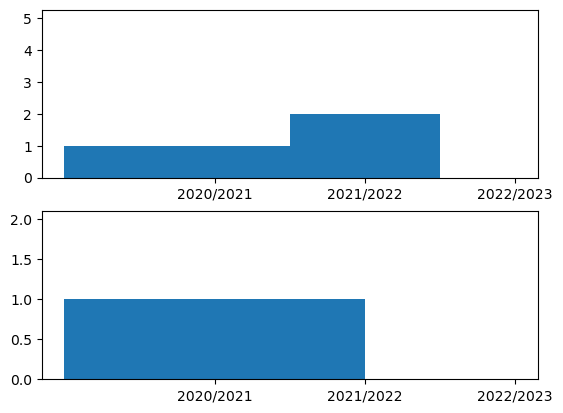

In [27]:
team_a_home_season = [ str(x.season_start.year)+"/"+str(x.season_end.year) for x in previous_matches if x.home_team==team_a ]
team_a_away_season = [ str(x.season_start.year)+"/"+str(x.season_end.year) for x in previous_matches if x.away_team==team_a ]

team_a_home_scores = [ x.home_team_score for x in previous_matches if x.home_team==team_a ]
team_b_away_scores = [ x.away_team_score for x in previous_matches if x.away_team==team_b ]
team_a_away_scores = [ x.away_team_score for x in previous_matches if x.away_team==team_a ]
team_b_home_scores = [ x.home_team_score for x in previous_matches if x.home_team==team_b ]

fig, (ax1,ax2) = plt.subplots(2,1)
ax1.bar(team_a_home_season, team_a_home_scores, team_b_away_scores)
ax2.bar(team_a_away_season, team_a_away_scores, team_b_home_scores)

plt.show()

In [29]:
team_b_away_scores

[2, 1, 0]